# ResNet-50

Train and validate the ResNet-50 model in PKLot dataset. The model is trained using transfer learning technique in tensorflow.keras library

In [1]:
# Set tensorflow backend to use only required GPU memory
import tensorflow as tf

def get_session_growth():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    return sess

sess = get_session_growth()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Instantiate the base model to extract features
HEIGHT = 49
WIDTH = 37

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
TRAIN_DIR = "pklot_dataset/cnn_dataset/train/"
BATCH_SIZE = 32

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                   class_mode='binary')

Found 5000 images belonging to 2 classes.


In [8]:
VALID_DIR = "pklot_dataset/cnn_dataset/valid/"
valid_datagen = ImageDataGenerator(
    rescale=1./255
)
validation_generator = valid_datagen.flow_from_directory(
        VALID_DIR,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 500 images belonging to 2 classes.


In [9]:
print(base_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 49, 37, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 55, 43, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 25, 19, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 25, 19, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [12]:
# Freeze the base model not to train
for layer in base_model.layers:
        layer.trainable = False

In [13]:
# Define the top layers to do classifiction
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(1, activation='sigmoid')(x)

tf_model = Model(inputs=base_model.input, outputs=pred)

In [14]:
print(tf_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 49, 37, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 55, 43, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 25, 19, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 25, 19, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [15]:
# choose the optimizers that works well with the dataset
tf_model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# tf_model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [16]:
# Set the number of train and validation examples, epochs and bact size

# # To train on full dataset, please uncomment this and comment sample dataset 
# nb_train_samples = 81406
# nb_validation_samples = 42384
# batch_size =  BATCH_SIZE

# To train on sample dataset
nb_train_samples = 5000
nb_validation_samples = 500
batch_size =  8
epochs = 10

In [17]:
# Fine-tune the top layers
tf_hist = tf_model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
625/625 [==============================] - 30s 49ms/step - loss: 0.2773 - acc: 0.8846 - val_loss: 0.8744 - val_acc: 0.5364
Epoch 2/10
625/625 [==============================] - 26s 42ms/step - loss: 0.1440 - acc: 0.9495 - val_loss: 1.0414 - val_acc: 0.5364
Epoch 3/10
625/625 [==============================] - 26s 42ms/step - loss: 0.1169 - acc: 0.9589 - val_loss: 1.1776 - val_acc: 0.5385
Epoch 4/10
625/625 [==============================] - 26s 42ms/step - loss: 0.1051 - acc: 0.9643 - val_loss: 1.2835 - val_acc: 0.5380
Epoch 5/10
625/625 [==============================] - 26s 42ms/step - loss: 0.1009 - acc: 0.9652 - val_loss: 1.3517 - val_acc: 0.5359
Epoch 6/10
625/625 [==============================] - 26s 42ms/step - loss: 0.0912 - acc: 0.9696 - val_loss: 1.4423 - val_acc: 0.5329
Epoch 7/10
625/625 [==============================] - 27s 43ms/step - loss: 0.0875 - acc: 0.9704 - val_loss: 1.4899 - val_acc: 0.5375
Epoch 8/10
625/625 [==============================] - 26s 42ms

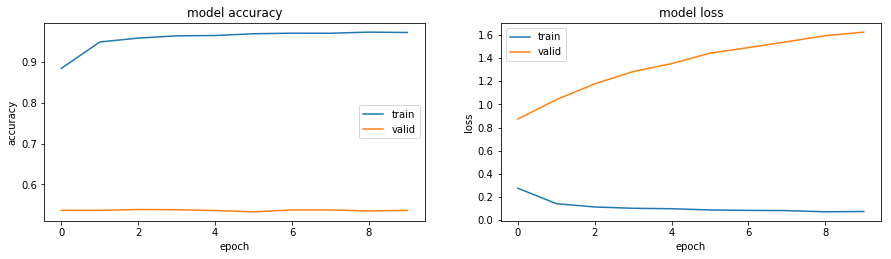

In [18]:
plt.figure(1, figsize = (15,8)) 
plt.subplot(221)  
plt.plot(tf_hist.history['acc'])  
plt.plot(tf_hist.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.subplot(222)  
plt.plot(tf_hist.history['loss'])  
plt.plot(tf_hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()

## Model prediction on validation dataset

In [19]:
from glob import glob
import numpy as np
from utils import load_image
import cv2

In [21]:
occupied_dir = "pklot_dataset/cnn_dataset/valid/Occupied/*.jpg"
empty_dir = "pklot_dataset/cnn_dataset/valid/Empty/*.jpg"

valid_images = glob(occupied_dir) + glob(empty_dir)

In [22]:
valid_sample_size = 250 # To run  on complete valid dataset. Please set this to 50000 (value greater than number of valid images)
valid_images = list(valid_images)
np.random.shuffle(valid_images)
valid_images = valid_images[:valid_sample_size] 

In [23]:
ground_truth = []
prediction = []
for img in valid_images:
    label = img.split("/")[-2]
    if label == "Occupied":
        ground_truth.append(1)
    else:
        ground_truth.append(0)
    image = load_image(img)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image_x = np.expand_dims(image, axis=0)
    image_x = preprocess_input(image_x)
    pred = tf_model.predict(image_x)
    pred = np.squeeze(pred)
    if pred > 0.98:
        prediction.append(1)
    else:
        prediction.append(0)
    

### Validate the model

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [25]:
# Show the classification metrics
print(classification_report(ground_truth, prediction, target_names=['Empty', 'Occupied']))

             precision    recall  f1-score   support

      Empty       0.97      0.95      0.96       130
   Occupied       0.94      0.97      0.95       120

avg / total       0.96      0.96      0.96       250



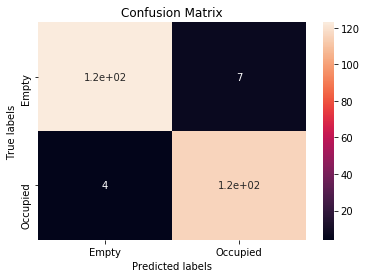

In [26]:
# confusion matrix
cm = confusion_matrix(ground_truth, prediction)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Empty', 'Occupied']); 
ax.yaxis.set_ticklabels(['Empty', 'Occupied']);

In [27]:
print("Confusion matrix")
print(cm)

Confusion matrix
[[123   7]
 [  4 116]]
